# Playing with cvxpy

## Introductory remarks 

This notebook uses `cvxpy`, available from [cvxpy.org]( https://www.cvxpy.org/install/index.html).

I have also installed `cvxopt` to make sure all the solvers that come packaged with cvxpy will work on my machine.

On my computer all this is available in the conda environment: `csp`

Some of this notebook relies on the GLPK_MI solver. This is a special solver designed for IP problems. 


To install GLPK (in /usr/local/):

- Download the latest version of GLPK from the [gnu](http://www.gnu.org/software/glpk/#downloading) website.
- `cd ~/Downloads`
- `tar -xzf glpk-4.43.tar.gz`
- `./configure -prefix=/usr/local`
- `make`
- `sudo make install`

At this point, you should have GLPK installed. 
To verify run: 
- `which glpsol`  
output: `/usr/local/bin/glpsol`


Introduction using GLPK [here](http://www.ibm.com/developerworks/linux/library/l-glpk1)


Good introduction to cvxpy is [integer-programming-in-python](https://towardsdatascience.com/integer-programming-in-python-1cbdfa240df2)


 Before you solve your own problem, consult this table to see which prepackaged cvpxy solver is best suited to your problem.

# The Knapsack Problem 

In [1]:
import cvxpy as cvx
import numpy as np

In [2]:
print(cvx.__version__)

1.0.25


In [8]:
cvx.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [9]:
# The data for the Knapsack problem
# P is total weight capacity of sack
# weights and utilities are also specified
P = 165
weights = np.array([23, 31, 29, 44, 53, 38, 63, 85, 89, 82])
utilities = np.array([92, 57, 49, 68, 60, 43, 67, 84, 87, 72])

# The variable we are solving for
selection = cvx.Variable(len(weights), boolean=True)

# The sum of the weights should be less than or equal to P
weight_constraint = weights * selection <= P

# Our total utility is the sum of the item utilities
total_utility = utilities * selection

In [11]:
# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
knapsack_problem = cvx.Problem(cvx.Maximize(total_utility), [weight_constraint])


In [12]:
# Solving the problem
knapsack_problem.solve(solver=cvx.GLPK_MI)

309.0

In [13]:
print(selection.value)

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]


# Area assignment

In [317]:
import cvxpy as cvx
import numpy as np
import utils.utils as u
import math as m
from matplotlib import pylab as plt

## Drawing and preps 

In [318]:
def draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='blue'):
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    xv, yv = np.meshgrid(x, y)    
    for i in range(xv.shape[0]):
        for j in range(yv.shape[1]):
            u._draw_box(xv[i,j], xv[i,j]+dx, yv[i,j], yv[i,j]+dy, edgecolor=edgecolor, facecolor=facecolor)
            
def draw_cell(x, y, dx, dy, edgecolor='black', facecolor='blue'):
    u._draw_box(x, x+dx, y, y+dy, edgecolor=edgecolor, facecolor=facecolor)

In [319]:
xmin, xmax, dx = 0, 0.5, .1
ymin, ymax, dy = 0, 1, .1

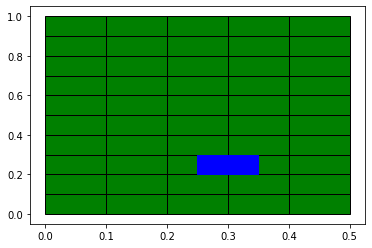

In [320]:
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
draw_cell(0.25, 0.2, 0.1, 0.1, edgecolor='blue', facecolor='blue')

In [321]:
# draws the allocation on the map
def draw_allocation(rxc_matrix, n_cells, n_robots):
    for r_idx in range(0, n_robots):
        m_dy = -dy       
        for c_idx in range(0, n_cells):    
            m_dx = dx*(c_idx % round((xmax-xmin)/dx))
            if (c_idx % round((xmax-xmin)/dx) == 0):    
                m_dy += dy*1            
            if rxc_matrix[r_idx][c_idx] == 1:            
                draw_cell(xmin+m_dx, ymin+m_dy, dx, dy, edgecolor=r_colors[r_idx], facecolor=r_colors[r_idx])            

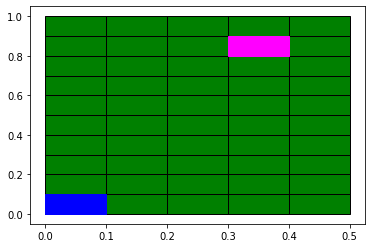

In [322]:
rxc_matrix = np.zeros((2, 100))
rxc_matrix[0,0] = 1
rxc_matrix[1,43] = 1


r_colors = ['blue', 'magenta', 'cyan']
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
draw_allocation(rxc_matrix, n_cells=100, n_robots=2)           

In [323]:
def fromCellToXY(c, x_lim, y_lim):
    """fromCellToXY:
       c: cell number,
       x_lim: (xmin, xmax, dx),
       y_lim: (ymin, ymax, dy),
    """
    xmin, xmax, dx = x_lim
    ymin, ymax, dy = y_lim    
    
    Area = (xmax-xmin)*(ymax-ymin)
    n_cells = round(Area/(dx*dy))
    n_cells_x = round((xmax-xmin)/dx)
    n_cells_y = round((ymax-ymin)/dy)

    assert n_cells == n_cells_x*n_cells_y, f"n_cells:{n_cells}, n_cells_x:{n_cells_x}, n_cells_y:{n_cells_y}"
    
    x = (xmax-xmin)*(c%n_cells_x)/n_cells_x   # x:(xmax-xmin)=c:n_cells   
    y = (ymax-ymin)*np.floor(c/n_cells_x)/n_cells_y
    
    return x, y


def fromXYToCell(x, y, x_lim, y_lim):
    """fromCellToXY:
       x, y: cell position,
       x_lim: (xmin, xmax, dx),
       y_lim: (ymin, ymax, dy),
    """
    xmin, xmax, dx = x_lim
    ymin, ymax, dy = y_lim    
    
    Area = (xmax-xmin)*(ymax-ymin)
    n_cells = round(Area/(dx*dy))
    n_cells_x = round((xmax-xmin)/dx)
    n_cells_y = round((ymax-ymin)/dy)
    
    dY = np.floor(y*n_cells_y/(ymax-ymin))*n_cells_x
    c = int(np.floor(n_cells_x*x/(xmax-xmin)) + dY)

    return c

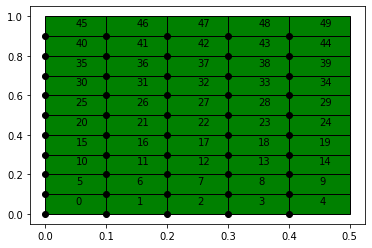

In [324]:
fig = plt.figure()
n_cells = 50
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
for c in range(0, n_cells):    
    x, y = fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
    plt.plot(x, y, marker='.', markersize=12, color='black')
    plt.gca().text(x+dx/2, y+dy/2, str(c))

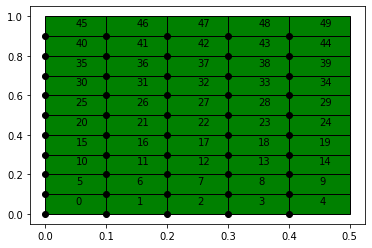

In [325]:
fig = plt.figure()
n_cells = 100
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
for x in np.arange(xmin, xmax, dx):
    for y in np.arange(ymin, ymax, dy):
        c = fromXYToCell(x, y, (xmin, xmax, dx), (ymin, ymax, dy))
        x, y = fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        plt.plot(x, y, marker='.', markersize=12, color='black')
        plt.gca().text(x+dx/2, y+dy/2, str(c))

In [326]:
def coverageFromXY(x, y, width, length, x_lim, y_lim):
    """coverageat(x, y, width, length, x_lim, y_lim)
        input:
          x, y: coordinate of the lower left corner of the coverage area
          width, length: width and length of the coverage area
          x_lim: (xmin, xmax, dx)
          y_lim: (ymin, ymax, dy) 
    """    
    xmin, xmax, dx = x_lim
    ymin, ymax, dy = y_lim    
    
    assert x >= xmin and x <= xmax
    assert y >= ymin and y <= ymax
    
    cells = []
    cells.append(fromXYToCell(x, y, x_lim, y_lim))
    cells.append(fromXYToCell(min(x+width, xmax-dx), y, x_lim, y_lim))
    cells.append(fromXYToCell(x, min(y+length, ymax-dy), x_lim, y_lim))    
    cells.append(fromXYToCell(min(x+width, xmax-dx), min(y+length, ymax-dx), x_lim, y_lim))
    
    return set(cells)

In [327]:
cells = coverageFromXY(x=0.3, y=0.0, width=2*dx, length=2*dy, x_lim=(xmin, xmax, dx), y_lim=(ymin, ymax, dy) )
print(cells)

{3, 4, 13, 14}


In [330]:
def coverageFromCell(c, width, length, rows, columns):
    """coverageat(c, width, length, x_lim, y_lim)
        input:
          c: cell number (bottom left point of the coverage area)
          width, length: width and length of the coverage area in number of cells
          rows, columns: number of rows and columns of the matrix representing the coverage area.
    """  
    
    n_cells = rows*columns
    assert c <= n_cells, f"cell number {c} must be less than {rows*columns}"
    
    coverage_cells = [c]
    xcells = list(range(c%columns, min(c%columns+width, columns)))
    ycells = list(range(c%columns+columns, length*columns, columns))
    
    for xc in xcells:
        ycells += list(range(xc+columns, length*columns, columns))
        
    xcells = list(c-c%columns+np.array(xcells))
    ycells = list(c-c%columns+np.array(ycells))

    coverage_cells+=xcells
    coverage_cells+=ycells
    
    coverage_cells = [c for c in coverage_cells if c < n_cells]
    return list(np.unique(coverage_cells))

coverage: [45, 46, 47]


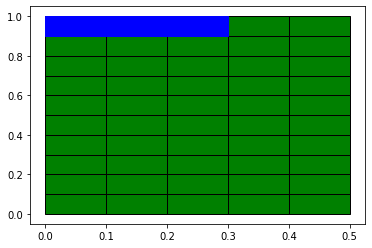

In [331]:
columns = round((xmax-xmin)/dx)
rows    = round((ymax-ymin)/dy)
coverage_cells = coverageFromCell(45, width=3, length=2, rows=rows, columns=columns)

print(f'coverage: {coverage_cells}')

fig = plt.figure()
n_cells = 100
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
for c in coverage_cells:
        x, y = fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        draw_cell(x, y, dx, dy, edgecolor='blue', facecolor='blue')        


## Solving the problem 

In [28]:
xmin, xmax, dx = 0, 1., 0.2
ymin, ymax, dy = 0, 1., 0.2

In [29]:
Area = (xmax-xmin)*(ymax-ymin)
n_cells = round(Area/(dx*dy))

mapr = np.array([.15, .6, .4])  # max area per each robot
n_robots = len(mapr)


print(f'Area     : {Area}')
print(f'n.cells  : {n_cells}')
print(f'n.robots : {n_robots}')

# robot_0 = cvx.Variable(n_cells, name='robot_0', boolean=True)
# robot_1 = cvx.Variable(n_cells, name='robot_1', boolean=True)
# rxc_matrix = np.vstack((robot_0,robot_1))

rxc_matrix = cvx.Variable((n_robots, n_cells), name='rxc_matrix', boolean=True)

Area     : 1.0
n.cells  : 25
n.robots : 3


In [30]:
# a few tests
# p_rxc_matrix = cvx.Parameter((n_robots, n_cells), name='p_rxc_matrix', boolean=True)
# p_rxc_matrix.value = np.ones((n_robots, n_cells))

# print(p_rxc_matrix.value)

# print(rxc_matrix[1,:])
# print(rxc_matrix.shape)
# print(sum(p_rxc_matrix[0,:]).value)
# round(mapr[0]*n_cells), round(mapr[1]*n_cells)

### Define the constraints

In [31]:
constraints = [sum(rxc_matrix[0,:]) <= round(mapr[0]*n_cells),  #(sum of column)
              sum(rxc_matrix[1,:]) <= round(mapr[1]*n_cells)              
             ]

for i in range(rxc_matrix.shape[1]):
    constraints.append(sum(rxc_matrix[:,i]) <= 1)

In [32]:
# constraints

### Define the objective function

In [33]:
# Our total utility is the area that we cover
total_utility = cvx.sum(rxc_matrix) #- cvx.tv(rxc_matrix)

### Run the solver

In [34]:
# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
area_problem = cvx.Problem(cvx.Maximize(total_utility), constraints)

In [35]:
# Solving the problem
area_problem.solve(solver=cvx.GLPK_MI)
#area_problem.solve(solver=cvx.ECOS)
print("optimal objective value: {}".format(area_problem.value))

optimal objective value: 25.0


In [36]:
print('Solution: ')
print(rxc_matrix.value)

Solution: 
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  1.]]


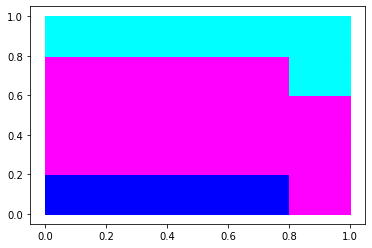

In [37]:
r_colors = ['blue', 'magenta', 'cyan']
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')
draw_allocation(rxc_matrix.value, n_cells=n_cells, n_robots=n_robots)           

# Greedy algorithm

In [369]:
n_robots = 3
robot_area_coverage = [[4, 4, 0],  # width, length, rotation
                       [5, 3, 0],
                       [1, 2, 0]]


xmin, xmax, dx = 0, 1., 0.2
ymin, ymax, dy = 0, 1., 0.2

Area = (xmax-xmin)*(ymax-ymin)
n_cells = round(Area/(dx*dy))
n_cells_x = round((xmax-xmin)/dx)
n_cells_y = round((ymax-ymin)/dy)

## Finds the (sub)optimal allocation

In [370]:
def find_solution(n_robots, n_cells, robot_area_coverage):
    coverage = []
    cells = []
    rxc_matrix = np.zeros(n_cells)
    max_robot_area_coverage_value = 0

    for r in range(n_robots):
        min_intersection = list(range(n_cells)) # max number
        width=robot_area_coverage[r][0]
        length=robot_area_coverage[r][1]
        max_area_this_robot = width*length
        current_area_this_robot = 0

        for c in range(n_cells):
            coverage_cells = coverageFromCell(c, width=width, length=length, rows=n_cells_y, columns=n_cells_x)        
            print(f'robot {r}, area:{coverage_cells}')
            intersection = list(set(coverage_cells).intersection(coverage))

            # this is the amount of area that this robot is covering now.
            area_this_robot = len(coverage_cells)

            if area_this_robot >= current_area_this_robot:
                this_robot_in_cell = c
                current_area_this_robot = area_this_robot

            if len(intersection) == 0 and area_this_robot == max_area_this_robot:
                # this is a good solution for robot r
                print('Nothing more to gain: empty intersection found and max area met.')
                break

        coverage += coverage_cells


        # and saves the solution
        cells.append(this_robot_in_cell)
        rxc_matrix[c] = 1 
    return cells
    
#   coverage_value=sum(coverage)

In [371]:
cells = find_solution(n_robots, n_cells, robot_area_coverage)

robot 0, area:[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18]
Nothing more to gain: empty intersection found and max area met.
robot 1, area:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
robot 1, area:[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]
robot 1, area:[2, 3, 4, 7, 8, 9, 12, 13, 14]
robot 1, area:[3, 4, 8, 9, 13, 14]
robot 1, area:[4, 9, 14]
robot 1, area:[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
robot 1, area:[6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
robot 1, area:[7, 8, 9, 12, 13, 14, 17, 18, 19]
robot 1, area:[8, 9, 13, 14, 18, 19]
robot 1, area:[9, 14, 19]
robot 1, area:[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
robot 1, area:[11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24]
robot 1, area:[12, 13, 14, 17, 18, 19, 22, 23, 24]
robot 1, area:[13, 14, 18, 19, 23, 24]
robot 1, area:[14, 19, 24]
robot 1, area:[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
robot 1, area:[16, 17, 18, 19, 21, 22, 23, 24]
robot 1, area:[17, 18, 19, 22, 23, 24]
rob

In [372]:
rxc_matrix

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.])

In [373]:
cells, coverage

([0, 10, 4], [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 24])

In [374]:
sum(np.ones(len(coverage)))

17.0

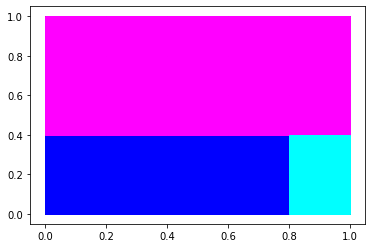

In [376]:
fig = plt.figure()
draw_paving(xmin, xmax, dx, ymin, ymax, dy, edgecolor='black', facecolor='green')


r_colors = ['blue', 'magenta', 'cyan']

for r in range(n_robots):
    width =robot_area_coverage[r][0]
    length=robot_area_coverage[r][1]
    coverage_cells = coverageFromCell(cells[r], width=width, length=length, rows=n_cells_x, columns=n_cells_y)
    for c in coverage_cells:
        x, y = fromCellToXY(c, (xmin, xmax, dx), (ymin, ymax, dy))
        draw_cell(x, y, dx, dy, edgecolor=r_colors[r], facecolor=r_colors[r])        



# References 

1. [Total variation in-painting](https://www.cvxpy.org/examples/applications/tv_inpainting.html)
2. [Cell tower coverage](http://examples.gurobi.com/cell-tower-coverage/)
3. [Max coverage](https://github.com/njtierney/maxcovr)
4. [cvxpy coverage](https://stackoverflow.com/questions/53333253/how-to-solve-a-facility-location-allocation-ip-problem-in-cvxpy)
5. [Find optimal location for x,y coordinates](https://stackoverflow.com/questions/47147813/finding-the-optimized-location-for-a-list-of-coordinates-x-and-y)
6. [What is CVXPY](https://www.cvxpy.org/tutorial/intro/index.html#parameters)